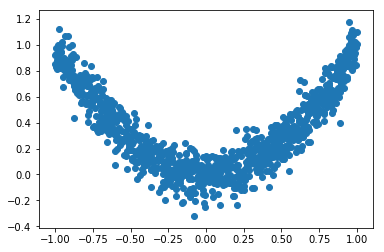

In [7]:
# the optimizer test framework is from: https://morvanzhou.github.io/tutorials/machine-learning/torch/3-06-optimizer/
# the idea is from fast.ai's blog and AdamW implementation in fastai 
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
from adamW import AdamW
%matplotlib inline
torch.manual_seed(1)    # reproducible

LR = 0.01
BATCH_SIZE = 32
EPOCH = 12
WD = 0.1

# fake dataset
x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)
y = x.pow(2) + 0.1*torch.normal(torch.zeros(*x.size()))

# plot dataset
plt.scatter(x.numpy(), y.numpy())
plt.show()

# data loader
torch_dataset = Data.TensorDataset(x, y)
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,)

In [8]:
# simple 2 layer network
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)   # hidden layer
        self.predict = torch.nn.Linear(20, 1)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

#  build net for every optimizer

net_Adam        = Net()
net_W           = Net()


In [9]:

optim_adam  = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99), weight_decay = WD)
optim_W     = AdamW(net_W.parameters(), lr=LR, betas=(0.9, 0.99), weight_decay = WD)
loss_func = torch.nn.MSELoss()


In [10]:
losses = []

for epoch in range(EPOCH):
    print('Epoch: ', epoch)
    for step, (b_x, b_y) in enumerate(loader):

        # 对每个优化器, 优化属于他的神经网络
        
        output = net_Adam(b_x)              # get output for every net
        loss = loss_func(output, b_y)  # compute loss for every net
        optim_adam.zero_grad()                # clear gradients for next train
        loss.backward()                # backpropagation, compute gradients
        optim_adam.step()                     # apply gradients
        losses.append(loss.data.numpy())     # loss recoder

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11


In [11]:
lossesW = []
wd = 0
for epoch in range(EPOCH):
    print('Epoch: ', epoch)
    for step, (b_x, b_y) in enumerate(loader):
        
        output = net_W(b_x)              
        loss = loss_func(output, b_y)  
        optim_W.zero_grad()             
        loss.backward()               
        
        # the block below changes weight decay in adam
        for group in optim_W.param_groups:
            for param in group['params']:
                param.data = param.data.add(-wd * group['lr'], param.data)
                
        optim_W.step()                    
        lossesW.append(loss.data.numpy())  

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11


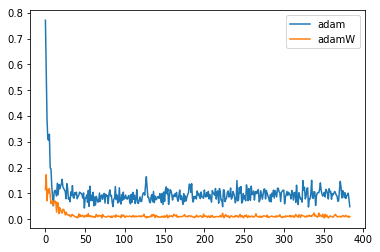

In [12]:
plt.plot(losses, label = 'adam')
plt.plot(lossesW, label = 'adamW')
plt.legend(loc='best')

# I have rerun this code so this fugure is not in a specific situation